In [1]:
#export
"""This is for optimizing the hell out of cli tools. Optimizations
that focus around a specific cli should be included close to their
definitions, so this is for optimizations that unusually span multiple
clis, and serve as examples of how to create optimization passes.

See over the `LLVM optimizer tutorial <llvm.html>`_ for more background."""
import k1lib.cli as cli
from k1lib.cli.typehint import *
from k1lib.cli.init import yieldT
from collections import defaultdict
import k1lib, platform

__all__ = ["dummy"]

In [2]:
#export
def dummy():
    """Does nothing. Only here so that you can read the source code"""

In [3]:
n = 10_000_000
tOpt._passes, tOpt._serialPasses

([[<function k1lib.cli.typehint.serialOpt(c, t, metadata=None)>, 2]],
 [[<function k1lib.cli.typehint.addSerialOpt.<locals>.inner(cs, ts, metadata)>,
   (k1lib.cli.init.serial,),
   15],
  [<function k1lib.cli.structural.oTranspose1(cs, ts, metadata)>,
   (k1lib.cli.structural.transpose, k1lib.cli.modifier.apply),
   3],
  [<function k1lib.cli.structural.oUnsqueeze(cs, ts, metadata)>,
   (k1lib.cli.modifier.apply,),
   4],
  [<function k1lib.cli.conv.<lambda>(cs, ts, _)>,
   (k1lib.cli.conv.toList, k1lib.cli.conv.toList),
   3],
  [<function k1lib.cli.conv.<lambda>(cs, ts, _)>,
   (k1lib.cli.conv.toIter, k1lib.cli.conv.toIter),
   3],
  [<function k1lib.cli.conv.<lambda>(cs, ts, _)>,
   (k1lib.cli.conv.toSet, k1lib.cli.conv.toSet),
   3],
  [<function k1lib.cli.conv.<lambda>(cs, ts, _)>,
   (k1lib.cli.conv.toRange, k1lib.cli.conv.toRange),
   3],
  [<function k1lib.cli.kxml.oCatNode(cs, ts, _)>,
   (k1lib.cli.inp._cat, k1lib.cli.kxml.node),
   3],
  [<function k1lib.cli.optimizations.s

In [4]:
#export
#tOpt.clearPasses(); tOpt.n = 10
def setHints(cs, ts, metadata):
    s = cs[0]; t = ts[0]; #print(f"hints {metadata} - {[c.__class__.__name__ for c in s.clis]}")
    for c in s.clis: c._inHint = t; t = c._typehint(t) or tAny(); c._outHint = t
tOpt.addPass(setHints, [cli.serial], 14) # for adding extra hints to cli objects
def oUnwrapSerial(cs, ts, metadata):
    if len(metadata["route"]) < 2: return None
    s = metadata["route"][-2]
    if s == "apply" or s == "mtmS" or s == "oneToMany": return None
    #print(f"unwrap serial {metadata} {[c.__class__.__name__ for c in cs[0].clis]}")
    return cs[0].clis
tOpt.addPass(oUnwrapSerial , [cli.serial], 1) # for unwrapping serial
tOpt.addPass(lambda cs, ts, _: [cs[1], cs[0]], [cli.toList, cli.head]) # for swapping heads around
def stripSerial(c):
    if c is None: return None
    while isinstance(c, cli.serial) and len(c.clis) == 1: c = c.clis[0]
    return c
def prepareSerial(c): # basically prepares input clis so that they can be recursively optimized by `apply` and `mtmS`
    c = stripSerial(c); return cli.serial(c) if isinstance(c, cli.serial) else cli.serial(cli.serial(c))
def oApply(cs, ts, metadata): # for going into apply
    a = cs[0]; t = ts[0]; #print(f"apply {metadata} {cs} {ts} {a.f.clis}")
    if a.column is None and isinstance(a.f, cli.BaseCli):
        metadata["route"].append("apply");
        res = stripSerial(cli.typehint.serialOpt(prepareSerial(a.f), t.item(), metadata))
        metadata["route"].pop(); #print(f"res: {res}")
        if res is not None: return [cli.apply(res)]
    return None
tOpt.addPass(oApply, [cli.apply])

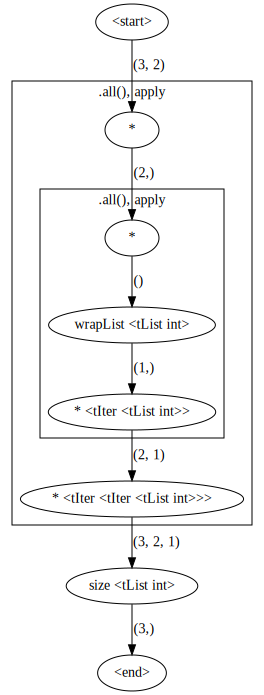

<trace object>

In [5]:
[[1, 2], [3, 4], [5, 6]] | tOpt() | cli.trace() | cli.unsqueeze(2) | cli.shape()

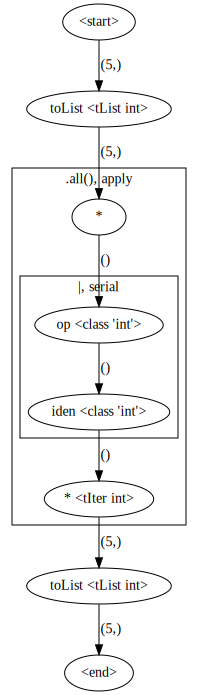

<trace object>

In [6]:
tOpt.addPass(lambda cs, ts, _: [cs[0]], [cli.iden, cli.iden])
range(5) | tOpt() | cli.trace() | cli.toList() | cli.apply((cli.op()**2).op_hint(int) | cli.iden() | cli.iden()) | cli.toList()

In [7]:
#export
def oMtmS(cs, ts, metadata):
    m = cs[0]; n = len(m.clis); newClis = []; atLeastOnce = False
    ts = m._inpTypeHintExpand(ts[0])
    metadata["route"].append("mtmS")
    for c, t in zip(m.clis, ts):
        res = stripSerial(cli.typehint.serialOpt(prepareSerial(c), t, metadata))
        if res is not None: atLeastOnce = True
        newClis.append(res)
    metadata["route"].pop()
    if atLeastOnce: return [cli.mtmS(*newClis)]
tOpt.addPass(oMtmS, [cli.mtmS])

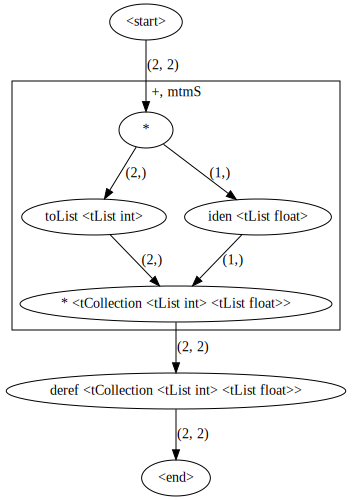

<trace object>

In [8]:
[[1, 2], [3.2]] | tOpt() | cli.trace() | (cli.toList() + cli.iden()) | cli.deref()

In [9]:
#export
def oOneToMany(cs, ts, metadata):
    o = cs[0]; t = ts[0]; atLeastOnce = False; newClis = []
    metadata["route"].append("oneToMany")
    for c in o.clis:
        res = stripSerial(cli.typehint.serialOpt(prepareSerial(c), t, metadata))
        if res is not None: atLeastOnce = True
        newClis.append(res)
    metadata["route"].pop()
    if atLeastOnce: return [cli.oneToMany(*newClis)]
tOpt.addPass(oOneToMany, [cli.oneToMany])

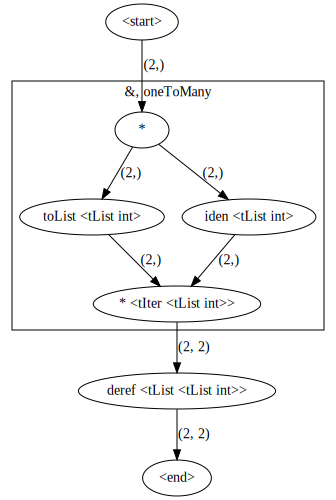

<trace object>

In [10]:
[1, 2] | tOpt() | cli.trace() | (cli.toList() & cli.iden()) | cli.deref()

In [11]:
#export
def basics():
    tOpt.addPass(oApply, [cli.apply])
    tOpt.addPass(oMtmS, [cli.mtmS])
    tOpt.addPass(oOneToMany, [cli.oneToMany])

In [12]:
with k1lib.timer() as t1: range(n) | cli.toList() | cli.head(10) | cli.deref()
with k1lib.timer() as t2: range(n) | tOpt() | cli.toList() | cli.head(10) | cli.deref() | yieldT
assert t2()*10 < t1(); t1(), t2()

(0.20223689079284668, 0.00020694732666015625)

In [13]:
#export
def oFileLength(cs, ts, _):
    c, s = cs;
    if s.idx != 0: return None
    return [cli.aS(lambda fn: None | cli.cmd(f"wc -l {fn}") | cli.item() | cli.op().split(" ")[0].ab_int())]
if platform.system() in ["Linux", "Darwin"]: tOpt.addPass(oFileLength, [cli.cat().__class__, cli.shape], 9)

In [17]:
%%time
"~/ssd/data/celeb-a/CelebA/Anno/list_attr_celeba.txt" | tOpt() | cli.cat() | cli.shape(0) | yieldT

CPU times: user 4.51 ms, sys: 73 µs, total: 4.58 ms
Wall time: 10.7 ms


202601

In [18]:
%%time
"~/ssd/data/celeb-a/CelebA/Anno/list_attr_celeba.txt" | cli.cat() | cli.shape(0)

CPU times: user 9.78 ms, sys: 3.23 ms, total: 13 ms
Wall time: 13 ms


202601

In [16]:
!../../export.py cli/optimizations

Current dir: /home/kelvin/repos/labs/k1lib, ../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.1
Uninstalling k1lib-1.1:
  Successfully uninstalled k1lib-1.1
running install
/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/S